In [1]:
import math 
import pandas_datareader as web 
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential  #load_model
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
from datetime import date, datetime, time, timedelta

In [44]:
main_company = 'BNB-USD'

start = datetime(2010, 1, 1)

df = web.DataReader(main_company, 'yahoo', start)
df['Date']=df.index

df=df.reset_index(drop=True)

In [45]:
# get the number of rows and columns in the data set
df.shape

(1699, 7)

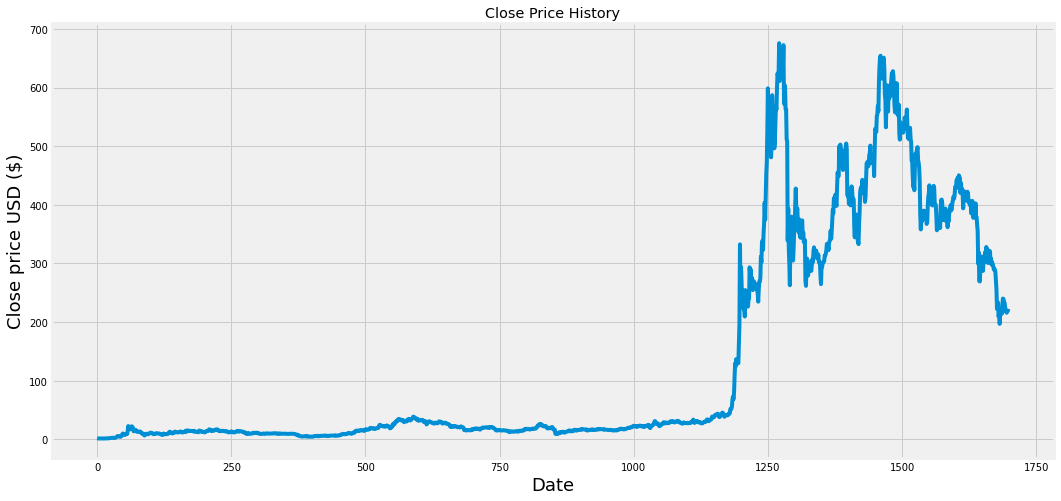

In [46]:
# visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.show()

In [47]:
# create a new df with only the "close" column
data = df.filter({'Close'})
# convert the df to a numpy array
dataset = data.values
# get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1360

In [48]:
# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data


array([[7.12590782e-04],
       [4.24934910e-04],
       [2.37490711e-04],
       ...,
       [3.21170739e-01],
       [3.22572579e-01],
       [3.28067338e-01]])

In [49]:
## create the training data set
# create the scaled training data set
train_data = scaled_data[0:training_data_len, :]
# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])

print(x_train)
print(y_train)

[array([7.12590782e-04, 4.24934910e-04, 2.37490711e-04, 1.38392138e-05,
       2.61445958e-04, 1.21956635e-04, 2.97994171e-05, 1.00211496e-04,
       0.00000000e+00, 2.43216234e-04, 1.53387773e-04, 1.69229328e-04,
       9.44859739e-05, 1.50391510e-04, 5.68695742e-05, 3.07561699e-04,
       5.39193387e-04, 5.08429755e-04, 6.41704110e-04, 6.03331086e-04,
       3.57726860e-04, 7.21787336e-04, 8.30453615e-04, 8.51116067e-04,
       1.06336108e-03, 1.45558907e-03, 1.60928841e-03, 1.59800075e-03,
       1.88317916e-03, 1.95841231e-03, 1.63173076e-03, 1.44326311e-03,
       1.77445364e-03, 1.74196952e-03, 1.88043522e-03, 2.44503751e-03,
       3.68716539e-03, 4.67874949e-03, 6.29861403e-03, 6.08966181e-03,
       6.35143383e-03, 5.43754496e-03, 5.44318136e-03, 4.19148667e-03,
       4.93774822e-03, 5.59992134e-03, 7.49013168e-03, 1.11530006e-02,
       1.27513726e-02, 1.15861089e-02, 1.08239758e-02, 9.39023561e-03,
       1.05688190e-02, 1.02410546e-02, 1.08687275e-02, 1.19042315e-02,
     

In [50]:
# convert the x_train and y_train to number arrays
x_train, y_train = np.array(x_train), np.array(y_train)

In [51]:
# reshape the data, input [samples, time steps, features] which is require for LSTM
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1300, 60, 1)

In [52]:
# build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [53]:
# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [54]:
# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

1300/1300 [==============================] - 29s 20ms/step - loss: 0.0030


In [55]:
## create the testing data set
# create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60:, :]
# create the data sets x_test nad y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [56]:
# convert the data to a numpy array
x_test = np.array(x_test)

In [57]:
# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

In [58]:
# get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)


11/11 [==============================] - 1s 17ms/step


In [59]:
# get the rmse (root mean squared error)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

1.9104427461427222

C:\Users\Dell\AppData\Local\Temp\ipykernel_12992\3363781652.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Prediction'] = predictions


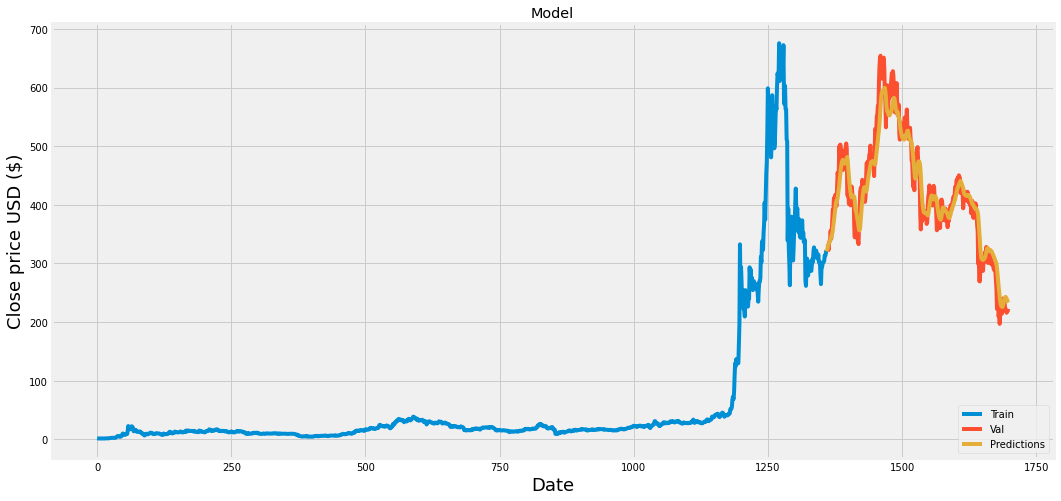

In [60]:
# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Prediction'] = predictions
# visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Prediction']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [61]:
# show the valid and predicted prices
valid

,Close,Prediction
1360,333.549591,320.738800
1361,333.484009,325.461853
1362,331.103119,329.968781
1363,322.747742,333.446289
1364,334.918793,334.852753
...,...,...
1694,219.300095,241.906281
1695,216.015457,239.917770
1696,218.035233,237.337616
1697,218.980316,235.069397


In [62]:
valid.index=pd.to_datetime(df['Date'].loc[training_data_len:].copy())
valid.to_csv('../out/LSTM/BNB-USD.csv')
valid

,Close,Prediction
Date,,
2021-07-31,333.549591,320.738800
2021-08-01,333.484009,325.461853
2021-08-02,331.103119,329.968781
2021-08-03,322.747742,333.446289
2021-08-04,334.918793,334.852753
...,...,...
2022-06-30,219.300095,241.906281
2022-07-01,216.015457,239.917770
2022-07-02,218.035233,237.337616


In [63]:
temp = df['Date'].loc[training_data_len:]
print(temp)

1360   2021-07-31
1361   2021-08-01
1362   2021-08-02
1363   2021-08-03
1364   2021-08-04
          ...    
1694   2022-06-30
1695   2022-07-01
1696   2022-07-02
1697   2022-07-03
1698   2022-07-04
Name: Date, Length: 339, dtype: datetime64[ns]
